## Notebook to train an Advection-Aware AutoEncoder for a parametric 2D Linear Advection example


Consider the advection of a circular Gaussian pulse traveling in the positive $y-$direction through a rectangular domain, $\Omega = [-100,100] \times [0, 500]$ at a constant speed, $c$. The analytical solution is given by
\begin{align}\label{eq:Gaussian_pulse}
    u(x,y) = \exp{ \bigg\{ -\left(\frac{(x -x_0)^2}{2 \sigma_x^2} + \frac{(y - y_0 - ct)^2}{2 \sigma_y^2} \right) \bigg\} },
\end{align}
where $(x_0, y_0)$ is the initial location of the center of the pulse, $\sigma_x$ and $\sigma_y$ define the support of the pulse in the $x$ and $y$ directions, respectively. The domain is uniformly discretized into $100701$ computational nodes using $\Delta x = 1$ and $\Delta y = 1$.

#### Discussion 
1. Both decoders train well with pulses of larger support (>= 10)
2. The difference between shift prediction and reconstruction becomes significant with sigma = 5 and lower when using RMSE loss function.
3. Using the Rel RMSE loss function does not alter the trend significantly.
4. Using Max Absolute error makes things worse and widens the training gap between shift and reconstruction error.
5. Using swish activation function improves the error for sigma = 5 and sigma = 2.5.
6. SeriesEncoder model with both losses only trains the shift decoder and not the NN map following it. But if the shift decoder is not included in the loss then the NN map trains well. 


### Observations
1. Scaling data seems to have a measurable impact on accuracy. Scaling the parameter value separately from the snapshot data helps training. 
2. Augmenting input vector with parameter value (support size or speed) offers marginal benefit.
3. Lower batch size helps training.
3. Increasing the size of the latent space leads to better reconstruction. In general, autoencoders tend to fail reconstructing high-frequent noise (i.e. sudden, big changes across few pixels) due to the choice of MSE as loss function (see our previous discussion about loss functions in autoencoders). Small misalignments in the decoder can lead to huge losses so that the model settles for the expected value/mean in these regions. For low-frequent noise, a misalignment of a few pixels does not result in a big difference to the original image. However, the larger the latent dimensionality becomes, the more of this high-frequent noise can be accurately reconstructed.

See https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html

Compare reconstruction error over latent dimensionality. 

In [51]:
## Load modules
%matplotlib inline

import numpy as np
import scipy
import os
import gc
import time
import importlib
from importlib import reload as reload


from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

import tensorflow as tf
print("Tensorflow v"+str(tf.__version__))
if tf.__version__ == '1.15.0':
    tf.compat.v1.enable_eager_execution()
elif tf.__version__.split('.')[0] == 2: # in ['2.2.0','2.3.0']:
    print("Setting Keras backend datatype")
    tf.keras.backend.set_floatx('float32')
    tf.debugging.set_log_device_placement(True)

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, LSTM, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
# tf.keras.backend.set_floatx('float64')

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText


# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'lines.markersize':10,
                     'axes.labelsize': 16, # fontsize for x and y labels (was 10)
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','g','b','m','y','c'])
markers = itertools.cycle(['p','d','o','^','s','x','D','H','v','*'])

try:
    os.listdir(base_dir)
except:
    base_dir = os.getcwd()
utils_dir  = os.path.join(base_dir,'../src/utils')
nn_dir  = os.path.join(base_dir,'../src/nn_model')
work_dir = os.path.join(base_dir,'../examples')
data_dir = '/gpfs/cwfs/sdutta/hfm_data/Pulse/'  #os.path.join(base_dir,'../data/')
model_dir = os.path.join(base_dir,'../data/saved_models/')
fig_dir  = os.path.join(base_dir,'../figures/')


os.chdir(utils_dir)
import data_utils as du
import tf_utils as tu
import plot_utils as pu

os.chdir(nn_dir)
import aa_autoencoder as aa
reload(aa)
os.chdir(work_dir)



Tensorflow v2.5.0
Num GPUs Available:  8


In [2]:
device = 'gpu:0' # select gpu:# or cpu:#
epochs_u = 6000

## Uncomment the following when training for variable pulse size
param_list = [ 5, 10, 20]; flag = 'sigma';  # pulse geometry as a parameter

## Uncomment the following when training for variable pulse speed
# param_list = [1, 2, 3, 4]; flag = 'speed';    # pulse speed as a parameter


In [3]:
## Load snapshot data
model ='Pulse'
soln_names = ['pulse']

snap_data = {}; times_offline = {}
c = {}; sigma = {}
snap_start = {}; snap_end = {}

for indx,val in enumerate(param_list):
    if flag == 'sigma':
        datafile = 'Gaussian2d_pulse_500x200_c1.00_sigma'+'%.4f'%val+'.npz'
    elif flag == 'speed':
        datafile = 'Gaussian2d_pulse_500x200_c'+'%.2f'%val+'_sigma5.0000.npz'
    data = np.load(os.path.join(data_dir, datafile))
    
    c[indx] = float(datafile.split('_c')[1].split('_')[0])
    sigma[indx] = float(datafile.split('_sigma')[1].split('.npz')[0])
    print("\n%d: Loading snapshots for c = %f, sigma = %f"%(indx, c[indx], sigma[indx]))
    
    snap_data[indx], times_offline[indx], nodes, Nx, Ny, snap_start[indx], snap_end[indx] = du.read_data(data, soln_names)
    
del data
gc.collect()


0: Loading snapshots for c = 1.000000, sigma = 5.000000
Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins

1: Loading snapshots for c = 1.000000, sigma = 10.000000
Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins

2: Loading snapshots for c = 1.000000, sigma = 20.000000
Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins


190

In [4]:
### Augment input snapshots for higher speed pulse systems

ctr = len(snap_data.keys())

for param in param_list:
    if param == 2:
        for indx,val in enumerate([41,]):
            datafile = 'gaussian2d_pulse_500x200_c%.2f_sigma5.0000_y0%d.npz'%(param,val)
            data = np.load(os.path.join(data_dir, datafile))

            c[ctr] = float(datafile.split('_c')[1].split('_')[0])
            sigma[ctr] = float(datafile.split('_sigma')[1].split('_y0')[0])
            print("\n%d: Loading snapshots for c = %f, sigma = %f"%(ctr, c[ctr], sigma[ctr]))
            snap_data[ctr], times_offline[ctr], nodes, Nx, Ny, \
                    snap_start[ctr], snap_end[ctr] = du.read_data(data, soln_names)
            ctr +=1
            
        del data
        gc.collect()
    
    elif param == 3:
        for indx,val in enumerate([41,42,]):
            datafile = 'gaussian2d_pulse_500x200_c%.2f_sigma5.0000_y0%d.npz'%(param,val)
            data = np.load(os.path.join(data_dir, datafile))

            c[ctr] = float(datafile.split('_c')[1].split('_')[0])
            sigma[ctr] = float(datafile.split('_sigma')[1].split('_y0')[0])
            print("\n%d: Loading snapshots for c = %f, sigma = %f"%(ctr, c[ctr], sigma[ctr]))
            snap_data[ctr], times_offline[ctr], nodes, Nx, Ny, \
                    snap_start[ctr], snap_end[ctr] = du.read_data(data, soln_names)
            ctr +=1
            
        del data
        gc.collect()

    elif param == 4:
        for indx,val in enumerate([41,42,43]):
            datafile = 'gaussian2d_pulse_500x200_c%.2f_sigma5.0000_y0%d.npz'%(param,val)
            data = np.load(os.path.join(data_dir, datafile))

            c[ctr] = float(datafile.split('_c')[1].split('_')[0])
            sigma[ctr] = float(datafile.split('_sigma')[1].split('_y0')[0])
            print("\n%d: Loading snapshots for c = %f, sigma = %f"%(ctr, c[ctr], sigma[ctr]))
            snap_data[ctr], times_offline[ctr], nodes, Nx, Ny, \
                    snap_start[ctr], snap_end[ctr] = du.read_data(data, soln_names)
            ctr +=1
            
        del data
        gc.collect()
    
    
if flag == 'speed':
    param_list = list(c.values())
    


In [5]:
## Prepare training snapshots

Nn = Nx * Ny

## number of steps to skip in selecting training snapshots for SVD basis
snap_incr=2

## Subsample snapshots for building reduced basis
Nt = {}
Nt_train = {}
for indx,val in enumerate(param_list):
    Nt[indx] = times_offline[indx].size
    Nt_train[indx] = times_offline[indx][:snap_end[indx]+1:snap_incr].size
    print('{5}: Using {0} training snapshots for {1} = {2:.2f} in time interval [{3:.2f},{4:.2f}] mins'.format(
                            Nt_train[indx], flag, param_list[indx], times_offline[indx][:snap_end[indx]+1:snap_incr][0]/60, 
                            times_offline[indx][:snap_end[indx]+1:snap_incr][-1]/60, indx))



0: Using 210 training snapshots for sigma = 5.00 in time interval [0.00,6.97] mins
1: Using 210 training snapshots for sigma = 10.00 in time interval [0.00,6.97] mins
2: Using 210 training snapshots for sigma = 20.00 in time interval [0.00,6.97] mins


In [6]:
def set_label(key):
    if key == 'pulse':
        ky = 'u'
    
    return ky

In [7]:
## Load shifted snapshots   
print("Loading high-fidelity shifted snapshots -----\n")

shifted_snap = {}
for indx,val in enumerate(param_list):
    if flag == 'sigma':
        shift_datafile = 'Shift_Gaussian2d_pulse_500x200_c1.00_sigma'+'%.4f'%val+'.npz'
    elif flag == 'speed':
        shift_datafile = 'Shift_Gaussian2d_pulse_500x200_c'+'%.2f'%val+'_sigma5.0000.npz'
    
    print("\nReading data from %s"%shift_datafile)
    shift_data = np.load(os.path.join(data_dir, shift_datafile))
    shifted_snap[indx] = {}
    for key in soln_names:
        shifted_snap[indx][key] = np.outer(shift_data[key].reshape((Nn,-1)),np.ones(Nt[indx]))

        print("%d: Loading %d shifted snapshots for c = %f, sigma = %f, key = %s"%(indx, 
                                                            shifted_snap[indx][key].shape[1], 
                                                            c[indx], sigma[indx], key))
        
del shift_data
gc.collect()


Loading high-fidelity shifted snapshots -----


Reading data from Shift_Gaussian2d_pulse_500x200_c1.00_sigma5.0000.npz
0: Loading 420 shifted snapshots for c = 1.000000, sigma = 5.000000, key = pulse

Reading data from Shift_Gaussian2d_pulse_500x200_c1.00_sigma10.0000.npz
1: Loading 420 shifted snapshots for c = 1.000000, sigma = 10.000000, key = pulse

Reading data from Shift_Gaussian2d_pulse_500x200_c1.00_sigma20.0000.npz
2: Loading 420 shifted snapshots for c = 1.000000, sigma = 20.000000, key = pulse


84

In [8]:
###  ***** Prepare Autoencoder input data *******
## 1. Concatenate parametric snapshots to prepare
##    input features for AA Autoencoder training

u = np.empty((0,Nn),)
u_shift = np.empty((0,Nn),)

p_max = np.asarray(param_list).max()
for indx,val in enumerate(param_list):
    u_snap = snap_data[indx]['pulse'][:,:snap_end[indx]+1:snap_incr].T    
    u = np.vstack((u,u_snap))
    u_shift_snap = shifted_snap[indx]['pulse'][:,:snap_end[indx]+1:snap_incr].T
    u_shift = np.vstack((u_shift,u_shift_snap))
    

validation_data = True
skip_start = snap_incr//2
if validation_data:
    u_val = np.empty((0,Nn),)
    u_val_shift = np.empty((0,Nn),)
    for indx,val in enumerate(param_list):
        u_val_snap = snap_data[indx]['pulse'][:,skip_start:snap_end[indx]+1:snap_incr].T
        u_val_shift_snap = shifted_snap[indx]['pulse'][:,skip_start:snap_end[indx]+1:snap_incr].T
        u_val = np.vstack((u_val, u_val_snap))
        u_val_shift = np.vstack((u_val_shift, u_val_shift_snap))
    

In [9]:
## Scale Input Features to lie between [0,1]

scaling=True

if scaling:
    u, u_shift, u_max, u_min = du.data_scaler(u, u_shift)

    if validation_data:
        u_val, u_val_shift, _, _ = du.data_scaler(u_val, u_val_shift, u_max, u_min)
        
else:
    u_max = np.maximum(u.max(), u_shift.max()); u_min = np.minimum(u.min(), u_shift.min())

    

In [10]:
###  ***** Prepare Autoencoder input data *******
## 2. Augment input feature states with scaled 
##    parameter values

u_sigma = np.empty((0,1),)
u_shift_sigma = np.empty((0,1),)

p_max = np.asarray(param_list).max()
for indx,val in enumerate(param_list/p_max):
    u_sigma = np.vstack((u_sigma,val*np.ones((Nt_train[indx],1))))
    u_shift_sigma = np.vstack((u_shift_sigma,val*np.ones((Nt_train[indx],1)) ))
    
u = np.hstack(( u,u_sigma))
u_shift = np.hstack(( u_shift, u_shift_sigma))


if validation_data:
    u_val_sigma = np.empty((0,1),)
    u_val_shift_sigma = np.empty((0,1),)
    for indx,val in enumerate(param_list/p_max):
        val_steps = np.minimum(times_offline[indx][skip_start:snap_end[indx]+1:snap_incr].size, Nt_train[indx])
        u_val_sigma = np.vstack((u_val_sigma, val*np.ones((val_steps,1)) ))
        u_val_shift_sigma = np.vstack((u_val_shift_sigma, val*np.ones((val_steps,1)) ))
        
        
u_val = np.hstack(( u_val, u_val_sigma))
u_val_shift = np.hstack(( u_val_shift, u_val_shift_sigma))


In [11]:
## Define minibatch generators for training and
## validation using Tensorflow Dataset API

batch_size = 24

size_buffer = max(list(Nt_train.values()))
# if flag == 'sigma':
#     size_buffer = Nt_train[0]
# elif flag == 'speed':
#     size_buffer = sum(list(Nt_train.values()))
    
u_train, u_val = tu.gen_batch_ae(u, u_shift, u_val, u_val_shift, 
                                 batch_size=batch_size, shuffle_buffer=size_buffer)


In [56]:
class AAautoencoder(tf.keras.models.Model):
    def __init__(self, latent_dim, act, size, **kwargs):
        super(AAautoencoder, self).__init__(**kwargs)
        
        self.latent_dim = latent_dim
        self.activation = act
        self.hidden_units = size
        try:
            self.l2_lam = kwargs['l2_lam']
        except:
            self.l2_lam = 1e-6
        
        self.encoder = Sequential()
        self.encoder.add(InputLayer(input_shape=(size[0],), name='Field'))
        self.encoder.add(Dense(size[1], activation=act,kernel_regularizer=regularizers.l2(self.l2_lam)))
        self.encoder.add(Dense(size[2], activation=act,kernel_regularizer=regularizers.l2(self.l2_lam)))
        self.encoder.add(Dense(size[3], activation=act,kernel_regularizer=regularizers.l2(self.l2_lam)))
        self.encoder.add(Dense(latent_dim, activation='linear'))
    
        
        self.shift = Sequential()
        self.shift.add(Dense(size[3], activation=act,kernel_regularizer=regularizers.l2(self.l2_lam)))
        self.shift.add(Dense(size[2], activation=act,kernel_regularizer=regularizers.l2(self.l2_lam)))
        self.shift.add(Dense(size[1], activation=act,kernel_regularizer=regularizers.l2(self.l2_lam)))
        self.shift.add(Dense(size[0], activation='linear',kernel_regularizer=regularizers.l2(self.l2_lam)))
        
        
        self.decoder = Sequential()
        self.decoder.add(Dense(size[3], activation=act,kernel_regularizer=regularizers.l2(self.l2_lam)))
        self.decoder.add(Dense(size[2], activation=act,kernel_regularizer=regularizers.l2(self.l2_lam)))
        self.decoder.add(Dense(size[1], activation=act,kernel_regularizer=regularizers.l2(self.l2_lam)))
        self.decoder.add(Dense(size[0], activation='linear',kernel_regularizer=regularizers.l2(self.l2_lam)))

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_config(self):
        return {"hidden_units": self.hidden_units, 
                "activation": self.activation, 
                "latent_dim": self.latent_dim}

    @classmethod
    def from_config(cls, config):
        return cls(**config)


size0 = u.shape[1]
size1 = int(np.floor(size0//160))
size2 = int(np.floor(size0//400))
size3 = int(np.floor(size0//1600))


size = np.array([size0, size1, size2, size3])
print(size)

latent_dim_u = 15

print('Output Size of Encoder Input Layer = %d'%size1)


[100702    629    251     62]
Output Size of Encoder Input Layer = 629


In [57]:
## Custom training loop for AA Autoencoder model

os.chdir(nn_dir)
reload(aa)
os.chdir(work_dir)

def train_AAautoencoder(epochs, train_dataset, val_dataset, latent_dim, actvn, size, Nt, **kwargs):
    
    loss_wt = kwargs['loss_weights']
    model = aa.AAautoencoder(latent_dim, actvn, size)
    
            
    try:
        learn_rate = kwargs['lr']
    except:
        learn_rate = 0.0001
    try:
        batch_size = kwargs['batch_size']
    except:
        batch_size = 64
    try:
        reg_wt = kwargs['reg']
    except:
        reg_wt = 0.02
        
    try:
        lb = kwargs['loss_lb']
    except:
        lb = 0.9
        
    try:
        decay_factor = kwargs['decay'][0]; decay_rate = kwargs['decay'][1]
    except:
        decay_factor = 15; decay_rate = 0.9
    
    try: 
        learning_rate_decay = kwargs['lr_decay']
        init_learn_rate = tf.keras.optimizers.schedules.ExponentialDecay(learn_rate, 
                                                        decay_steps=epochs*Nt//batch_size//decay_factor,
                                                        decay_rate=decay_rate, staircase=True)
    except:
        init_learn_rate = learn_rate
        
    optimizer = tf.keras.optimizers.Adam(learning_rate=init_learn_rate)
    

    train_loss = []
    val_loss = []
    shift_loss = []
    recon_loss = []
    lr = []
    regu_loss = []
    start_time = time.time()
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        # Iterate over the batches of the dataset.
        train_loss_value = 0; 
        shift_loss_value = 0; 
        recon_loss_value = 0;
        rloss_value = 0
        for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:

                # Run the forward pass of the layer.
              
                
                ## Encoded output for this minibatch
                encoded = model.encoder(x_batch_train, training=True)
                
                ## Shift Decoder Evaluation for this minibatch
                pred = model.shift(encoded, training=True)  
                
                ## True Decoder Evaluation for this minibatch
                recon = model.decoder(encoded, training=True)
                
                ## L2 Regularization Loss Component
                l2_loss=tf.add_n(model.losses)
                
                ## Compute the loss value for this minibatch.
                loss1 = tu.comb_loss(y_batch_train[:,:], pred, lb=lb, delta=0.5) #\
                loss2 = tu.comb_loss(x_batch_train[:,:], recon, lb=lb, delta=0.5) #\

                if epoch < kwargs['segmented']:
                    loss_value = loss_wt[0] * loss1 + loss_wt[1] * loss2 
                else:
                    loss_value = loss_wt[2] * loss1 + loss_wt[3] * loss2
                
                reg_loss = reg_wt*tf.sqrt(l2_loss)/(epoch+1)
                loss_value += reg_loss
                rloss_value +=reg_loss
                       
            train_loss_value += loss_value
            shift_loss_value += loss1
            recon_loss_value += loss2
            
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_variables,
                        unconnected_gradients=tf.UnconnectedGradients.ZERO) 
            ## Suppress warnings about zero gradients during training
            
            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Log every 10 batches.
            if step_train % 10 == 0:
                print("Training loss for batch %d: Shift: %.4e, Recon: %.4e, Reg: %.4e"
                    % ((step_train+1), float(loss1), float(loss2), float(reg_loss)))
                print("Seen so far: %s samples" % ((step_train + 1) * batch_size))
                
        train_loss.append((train_loss_value/(step_train + 1)).numpy())
        shift_loss.append((shift_loss_value/(step_train + 1)).numpy())
        recon_loss.append((recon_loss_value/(step_train + 1)).numpy())
        regu_loss.append((rloss_value/(step_train + 1)).numpy())
        
        # Run a validation loop at the end of each epoch.
        val_loss_value = 0; 
        for step_val, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            
            encoded_val = model.encoder(x_batch_val, training=False)
            pred_val = model.shift(encoded_val, training=False)
            recon_val = model.decoder(encoded_val, training=False)
            
            loss_val1 = tu.comb_loss(y_batch_val[:,:], pred_val, lb=lb,delta=0.5) #\
            loss_val2 = tu.comb_loss(x_batch_val[:,:], recon_val, lb=lb,delta=0.5) #\
            
            if epoch < kwargs['segmented']:
                val_loss_value += loss_wt[0] * loss_val1 + loss_wt[1] * loss_val2 
            else:
                val_loss_value += loss_wt[2] * loss_val1 + loss_wt[3] * loss_val2
        
        val_loss_value += rloss_value
        val_loss.append((val_loss_value/(step_val+1)).numpy())
        
        if learning_rate_decay:
            print("Epoch %d, Training Loss: %.4e, Validation Loss: %.4e. LR: %.4e" 
                  % (epoch, float(train_loss[-1]),float(val_loss[-1]),init_learn_rate(optimizer.iterations).numpy()))
            lr.append(init_learn_rate(optimizer.iterations).numpy())
        else:
            print("Epoch %d, Training Loss: %.4e, Validation Loss: %.4e. LR: %.4e" 
                  % (epoch, float(train_loss[-1]),float(val_loss[-1]),learn_rate))
            lr.append(learn_rate)

    
    end_time = time.time()
    print("****Total training time = {0}****\n".format(end_time - start_time))
    
    return model, train_loss, val_loss, shift_loss, recon_loss, lr


In [14]:
## Load AE model

load_ae_model = False

if load_ae_model:
    pre_trained_dir = '/gpfs/cwfs/sdutta/ae_data/pulse/ae_shift_inv_comb_models/saved_model_AA1'
    mnum = pre_trained_dir.split('saved_model_')[1]

    ## When using custom loss functions while training, there are two ways
    ## to load a saved model
    ## 1) If loaded model will not be used for retraining, then
    ##   use 'compile=False' option while loading so that TF does
    ##   search for loss functions
    u_autoencoder = tf.keras.models.load_model(pre_trained_dir+'/u_autoenc',compile=False)

    ae_training = np.load(pre_trained_dir+'/model_history_%s.npz'%mnum)

    print(ae_training['msg'])

    loss_u = ae_training['loss']
    vloss_u = ae_training['valloss'] 
    sloss_u = ae_training['shiftloss'] 
    rloss_u = ae_training['reconloss'] 
    lr_u = ae_training['lr']
    epochs_u = ae_training['epochs']

In [58]:
## Training the AA Autoencoder Model
actvn = 'swish'

if not load_ae_model:
    if flag == 'speed':
        u_autoencoder, loss_u, vloss_u, sloss_u, rloss_u, lr_u = train_AAautoencoder(epochs_u, u_train, u_val, 
                                                  latent_dim_u, actvn, np.aaray([size[0], size[2], size[3]]),
                                                  sum(list(Nt_train.values())),
                                                  batch_size = batch_size, loss_lb = 0.9,
                                                  segmented = 2500, decay = [15, 0.9],
                                                  loss_weights = [0.1, 0.88, 0.49, 0.49],
                                                  lr = 1e-4, lr_decay = True, reg = 0.02 )

    if flag == 'sigma':
        u_autoencoder, loss_u, vloss_u, sloss_u, rloss_u, lr_u = train_AAautoencoder(5, u_train, u_val, 
                                                              latent_dim_u, actvn, size,  
                                                              sum(list(Nt_train.values())),
                                                              batch_size = batch_size, loss_lb = 0.9,
                                                              segmented = 2500, decay = [17, 0.85],
                                                              loss_weights = [0.0, 0.98, 0.1, 0.88],
                                                              lr = 5e-4, lr_decay = True, reg = 0.02 )



TypeError: ('Keyword argument not understood:', 'reg')

In [16]:
u_autoencoder.encoder.summary()
u_autoencoder.shift.summary()
u_autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 629)               63342187  
_________________________________________________________________
dense_1 (Dense)              (None, 251)               158130    
_________________________________________________________________
dense_2 (Dense)              (None, 62)                15624     
_________________________________________________________________
dense_3 (Dense)              (None, 15)                945       
Total params: 63,516,886
Trainable params: 63,516,886
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 62)                992       
______________________

In [17]:
encoded_u = u_autoencoder.encoder(u).numpy()
shift_u = u_autoencoder.shift(encoded_u).numpy()
decoded_u = u_autoencoder.decoder(encoded_u).numpy()

encoded = encoded_u


print('\n*********AE shifted decoder reconstruction error*********\n')
print('u  Shift MSE: ' + str(np.mean(np.square(du.scaler_inverse(shift_u[:,:-1], u_max, u_min, scaling=scaling)-du.scaler_inverse(u_shift[:,:-1], u_max, u_min, scaling=scaling)))))

print('\n*********AE inverse decoder reconstruction error*********\n')
print('u  Reconstruction MSE: ' + str(np.mean(np.square(du.scaler_inverse(decoded_u[:,:-1], u_max, u_min, scaling=scaling)-du.scaler_inverse(u[:,:-1], u_max, u_min, scaling=scaling)))))



*********AE shifted decoder reconstruction error*********

u  Shift MSE: 3.6563311555177096e-08

*********AE inverse decoder reconstruction error*********

u  Reconstruction MSE: 1.6929295807663238e-07


In [18]:
## Save the trained AE model

save_ae_model = False
    
if save_ae_model:
    
    !mkdir -p /gpfs/cwfs/sdutta/ae_data/pulse/ae_shift_inv_comb_models/saved_model_AA1
    
    savedir = data_dir+'/gpfs/cwfs/sdutta/ae_data/pulse/ae_shift_inv_comb_models/saved_model_AA1'
    mnum = savedir.split('saved_model_')[1]
    
    ## To use TF SavedModel format with a custom training loop,
    ## call model.predict() on some input tensors first.
    ## Otherwise TF doesn't know the shape and dtype of input data
    ## it should be expecting, and thus cannot create it's weight 
    ## variables. When using model.fit() this step happens automatically.
    test_predict = u_autoencoder.predict(u)
    
    u_autoencoder.save(savedir+'/u_autoenc')
    msg = 'Sigma = [5,10,20], speed = [1],'\
    +'Trains both shift and reconstruction decoder,'\
    +'\nStep decay LR scheduler starting from 1e-4, Batch Size = 24,'\
    +'\nDecaying 10% every 96 epochs,'\
    +'\nFor epochs <=2500: Loss = 0.10*Shift + 0.88*True,'\
    +'\nFor epochs > 2500: Loss = 0.49*Shift + 0.49*True,'\
    +'\n90% NMSE + 10% Huber, L2 regularization, Scaling to [0,1],'\
    +'\nBoth Encoder input & Decoder ouput are augmented by parameter value'
    print("\n===========")
    print(msg)
    

    np.savez_compressed(savedir+'/model_history_%s'%mnum, 
                        loss = loss_u, valloss = vloss_u, 
                        shiftloss = sloss_u, reconloss = rloss_u,
                        lr = lr_u, epochs = epochs_u, 
                        msg=msg)


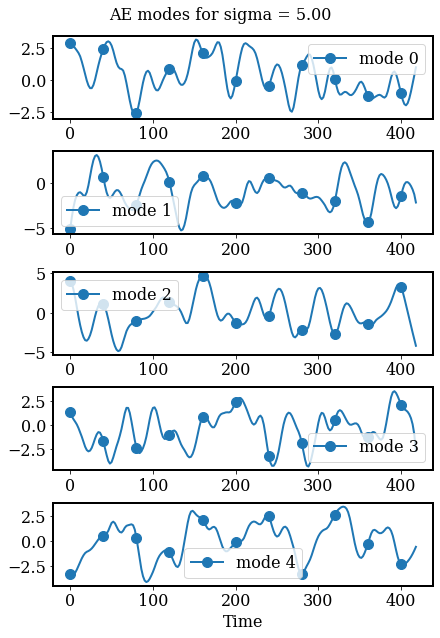

In [19]:
param_num = 0

def select_variable(param_num):
    p_indx = sum(list(Nt_train.values())[:param_num]); 
    encoded = encoded_u[p_indx:p_indx+Nt_train[param_num]]; ldim = latent_dim_u
    return encoded, ldim

def plot_latent_param_nums(param_num):

    num_rows = 5 #np.maximum(4, encoded.shape[1]//4)
    fig, ax = plt.subplots(nrows=num_rows,ncols=1,figsize=(6,num_rows*1.75),constrained_layout=True)    

    for ix,comp in enumerate([param_num]):
        encoded, ldim = select_variable(comp)
        
        for i in range(num_rows):
            tt = ax[i].plot(times_offline[comp][:snap_end[comp]+1:snap_incr],encoded[:,i],label='mode %d'%i,marker='o',markevery=20)
            ax[i].legend()
        ax[i].set_xlabel('Time')  
        fig.suptitle('AE modes for %s = %.2f'%(flag, param_list[param_num]),fontsize=16)  


plot_latent_param_nums(param_num)


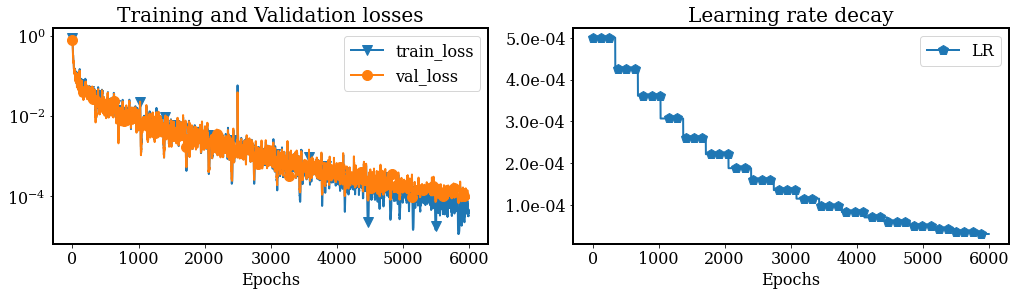

In [20]:
## Visualization losses and learning rate evolution
num_epochs_u = np.arange(epochs_u)

pu.plot_training(num_epochs_u, loss_u, vloss_u, lr_u)


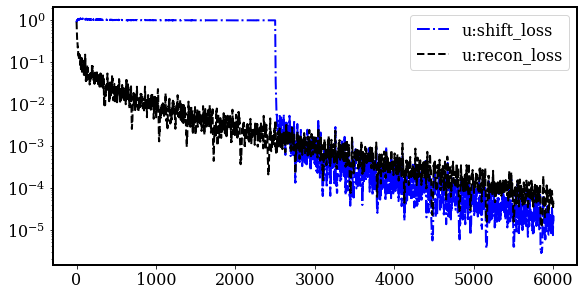

In [21]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4),constrained_layout=True)
ax.semilogy(num_epochs_u, sloss_u,'b-.',label='u:shift_loss')
ax.semilogy(num_epochs_u, rloss_u,'k--',label='u:recon_loss')
ax.legend()


In [37]:
### Predict using all high-fidelity data points 
### for parameter values in the training set

iparam = np.random.choice(len(param_list))
print("Testing AE predictions for %s = %f (parameter number = %d)"%(flag,param_list[iparam], iparam))
val = param_list[iparam]/p_max

u_test = np.hstack(( snap_data[iparam]['pulse'][:,:snap_end[iparam]+1].T, val*np.ones((Nt[iparam],1)) ))
u_shift_test = np.hstack(( shifted_snap[iparam]['pulse'][:,:snap_end[iparam]+1].T, val*np.ones((Nt[iparam],1)) ))

if scaling:
    u_test, u_shift_test, _, _ = du.data_scaler(u_test, u_shift_test, u_max, u_min)


encoded_u_test = u_autoencoder.encoder(u_test).numpy()
shift_u_test = u_autoencoder.shift(encoded_u_test).numpy()
recon_u_test = u_autoencoder.decoder(encoded_u_test).numpy()

pred_shift = {}
pred_shift['pulse'] = du.scaler_inverse(shift_u_test[:,:-1], u_max, u_min, scaling=scaling).T

pred_recon = {}
pred_recon['pulse'] = du.scaler_inverse(recon_u_test[:,:-1], u_max, u_min, scaling=scaling).T


Testing AE predictions for sigma = 20.000000 (parameter number = 2)


Text(0.5, 0.98, 'Comparing AE predictions of shifted snapshots \nfor sigma = 20 at t = 1.33 mins')

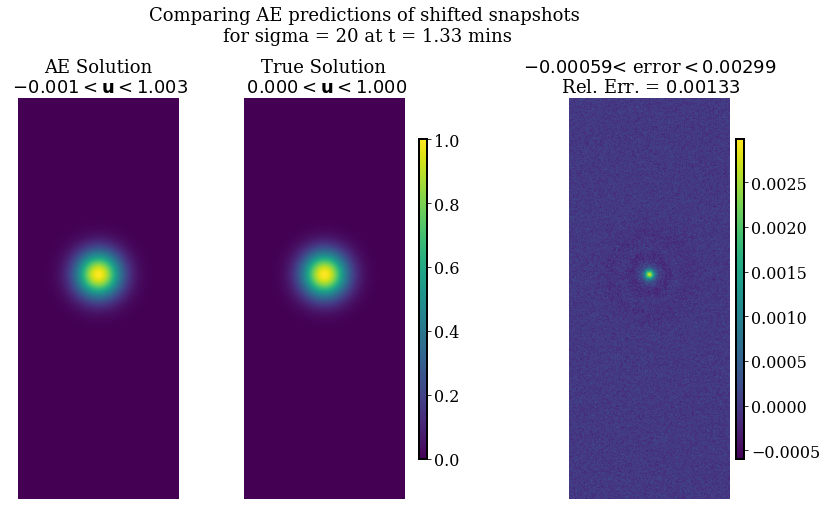

In [38]:
### Visualizing reconstruction of shifted snapshots using shift decoder  
    
fig = plt.figure(figsize=(14,8))
ky = 'pulse'; 
np.random.seed(2021)
iplot = 80 
fig.tight_layout()
fig.subplots_adjust(top=0.82)

pu.compare_soln(pred_shift,shifted_snap[iparam],iplot,times_offline[iparam],times_offline[iparam],Nx,Ny,ky,flag='AE')
fig.suptitle("Comparing AE predictions of shifted snapshots \nfor %s = %d at t = %.2f mins"%(flag, param_list[iparam], times_offline[iparam][iplot]/60),fontsize=18, y=0.98)


Text(0.5, 0.98, 'Comparing AE predictions of true snapshots \nfor sigma = 20 at t = 1.33 mins')

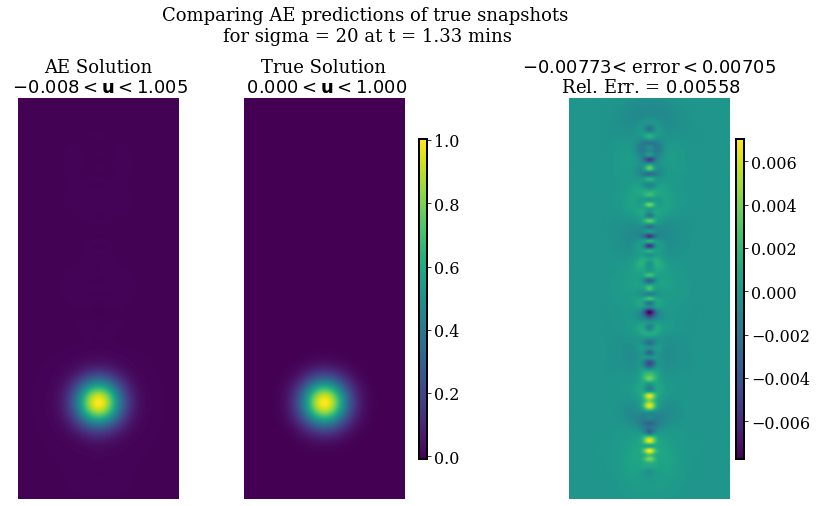

In [39]:
### Visualizing direct reconstruction using true decoder

fig = plt.figure(figsize=(14,8))
fig.tight_layout()
fig.subplots_adjust(top=0.82)

pu.compare_soln(pred_recon,snap_data[iparam],iplot,times_offline[iparam],times_offline[iparam],Nx,Ny,ky,flag='AE')
fig.suptitle("Comparing AE predictions of true snapshots \nfor %s = %d at t = %.2f mins"%(flag, param_list[iparam], times_offline[iparam][iplot]/60),fontsize=18, y=0.98)



In [40]:
## Compute rel error for decoded prediction of shifted and true solutions
rel_err_shift = {}
rel_err_recon = {}

for key in soln_names:
    true = shifted_snap[iparam][key][:,:snap_end[iparam]+1]
    true2 = snap_data[iparam][key][:,:snap_end[iparam]+1]
    rel_err_shift[key] = np.linalg.norm(pred_shift[key][:,:]-true,axis=0)/np.linalg.norm(true,axis=0)
    rel_err_recon[key] = np.linalg.norm(pred_recon[key][:,:]-true2,axis=0)/np.linalg.norm(true2,axis=0)


Text(0.5, 0.98, 'Relative errors of AE prediction for speed = 1')

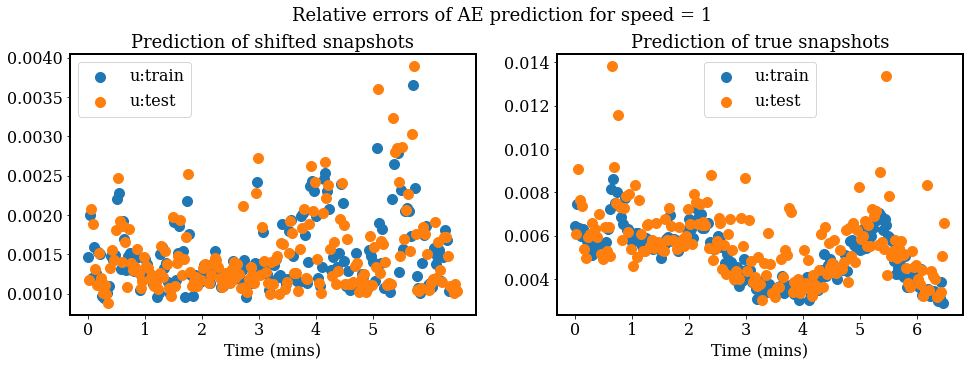

In [41]:
### Visualize relative errors for both decoders

fig = plt.figure(figsize=(16,5))
fig.tight_layout()
fig.subplots_adjust(top=0.85)
indx = times_offline[iparam][:snap_end[iparam]+1]/60
val_mark = int(times_offline[iparam][:snap_end[iparam]+1].size*1.0)-30
    
if validation_data:
    val_skip = 2
else:
    val_skip = 1

val_dict = {'v_data': validation_data, 'v_mark': val_mark, 'v_skip': val_skip, 'legend': True}
pu.plot_rel_err(indx,rel_err_shift,rel_err_recon,val_dict, ky='pulse')
fig.suptitle('Relative errors of AE prediction for speed = %d'%(c[iparam]),fontsize=18, y=0.98)



In [43]:
## Evaluate predictions on a dataset with unseen parameter value

new_test = True

if new_test:
    if flag == 'speed':
        test_param = np.random.choice([5,6,8])
        c_new = test_param; sigma_new = 8
        new_data = np.load(os.path.join(data_dir,'Gaussian2d_pulse_500x200_c%.2f_sigma5.0000.npz'%c_new))
        
    elif flag == 'sigma':
        test_param = np.random.choice([ 8, 16])  #3.3333, 4,
        c_new = 1; sigma_new = test_param
        new_data = np.load(os.path.join(data_dir,'Gaussian2d_pulse_500x200_c1.00_sigma%.4f.npz'%sigma_new))
        
    
    print("Chosen parameter: %s = %f"%(flag, test_param))
    print("Loading pre-computed true snapshots -----\n")
    
    snap_new, times_new, nodes2, Nx2, Ny2, snap_start_new, snap_end_new = du.read_data(new_data, soln_names)
    Nt_new = times_new.size

    
    if flag == 'speed':
        new_shift_data = np.load(os.path.join(data_dir,'Shift_Gaussian2d_pulse_500x200_c%.2f_sigma5.0000.npz'%c_new))
    elif flag == 'sigma':
        new_shift_data = np.load(os.path.join(data_dir,'Shift_Gaussian2d_pulse_500x200_c1.00_sigma%.4f.npz'%sigma_new))
    
    print("Loading pre-computed shifted snapshots -----\n")

    shifted_snap_new = {}
    for key in soln_names:
        tmp = new_shift_data[key].reshape((Nn,-1))
        shifted_snap_new[key] = np.outer(tmp,np.ones(Nt_new))

    del new_data
    del new_shift_data
    gc.collect()



    u_new = snap_new['pulse'][:,:snap_end_new+1].T
    u_shift_new = shifted_snap_new['pulse'][:,:snap_end_new+1].T
    
    u_new = np.hstack(( u_new, (test_param/p_max)*np.ones((Nt_new,1)) ))
    u_shift_new = np.hstack(( u_shift_new, (test_param/p_max)*np.ones((Nt_new,1)) ))

    if scaling:
        u_new, u_shift_new, _, _ = du.data_scaler(u_new, u_shift_new, u_max, u_min)

    encoded_u_new = u_autoencoder.encoder(u_new).numpy()
    shift_u_new = u_autoencoder.shift(encoded_u_new).numpy()
    recon_u_new = u_autoencoder.decoder(encoded_u_new).numpy()


    pred_shift_new = {}
    pred_shift_new['pulse'] = du.scaler_inverse(shift_u_new[:,:-1], u_max, u_min, scaling=scaling).T

    pred_recon_new = {}
    pred_recon_new['pulse'] = du.scaler_inverse(recon_u_new[:,:-1], u_max, u_min, scaling=scaling).T



Chosen parameter: sigma = 16.000000
Loading pre-computed true snapshots -----

Loaded 420 snapshots of dimension 100701 for ['pulse']  spanning times [0.000, 6.983] mins
Loading pre-computed shifted snapshots -----



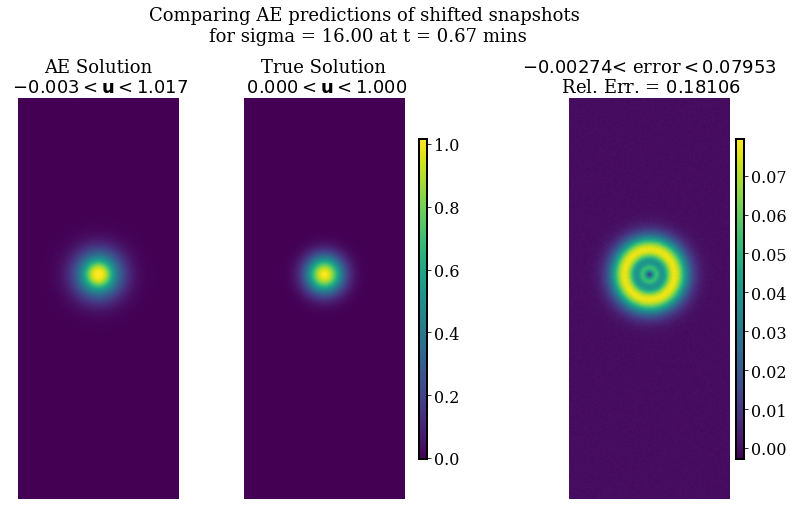

In [48]:
### Visualizing reconstruction of shifted snapshots using shift decoder
if new_test:
    fig = plt.figure(figsize=(14,8))
    ky = 'pulse'; iplot = 40 #np.random.choice(times_new.size)
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)
    pu.compare_soln(pred_shift_new,shifted_snap_new,iplot,times_new,times_new,Nx,Ny,ky,flag='AE')
    fig.suptitle("Comparing AE predictions of shifted snapshots \nfor %s = %.2f at t = %.2f mins"%(flag, test_param, times_new[iplot]/60),fontsize=18, y=0.98)



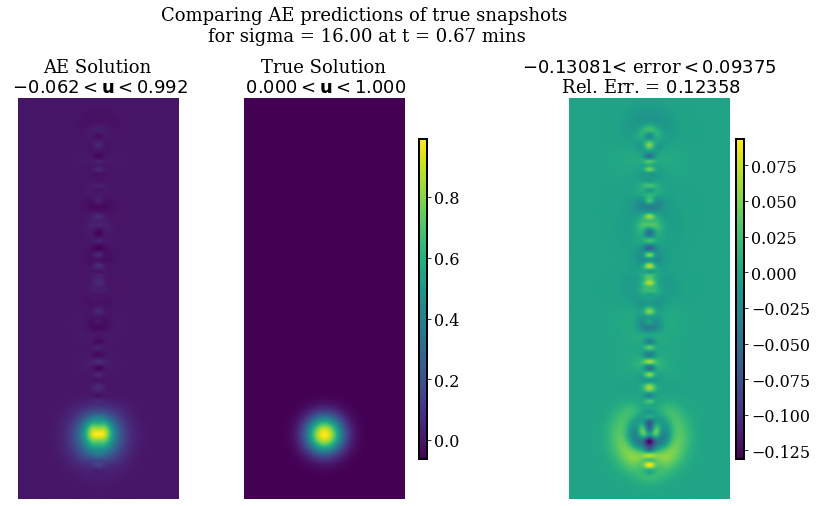

In [49]:
### Visualizing direct reconstruction using true decoder
if new_test:
    fig = plt.figure(figsize=(14,8))
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)
    pu.compare_soln(pred_recon_new,snap_new,iplot,times_new,times_new,Nx,Ny,ky,flag='AE')
    fig.suptitle("Comparing AE predictions of true snapshots \nfor %s = %.2f at t = %.2f mins"%(flag, test_param, times_new[iplot]/60),fontsize=18, y=0.98)



In [46]:
if new_test:
    ## Compute rel error for decoded prediction of shifted solutions
    rel_err_shift_new = {}
    rel_err_recon_new = {}

    for key in soln_names:
        true_new = shifted_snap_new[key][:,:snap_end_new+1]
        true2_new = snap_new[key][:,:snap_end_new+1]
        rel_err_shift_new[key] = np.linalg.norm(pred_shift_new[key][:,:]-true_new,axis=0)/np.linalg.norm(true_new,axis=0)
        rel_err_recon_new[key] = np.linalg.norm(pred_recon_new[key][:,:]-true2_new,axis=0)/np.linalg.norm(true2_new,axis=0)


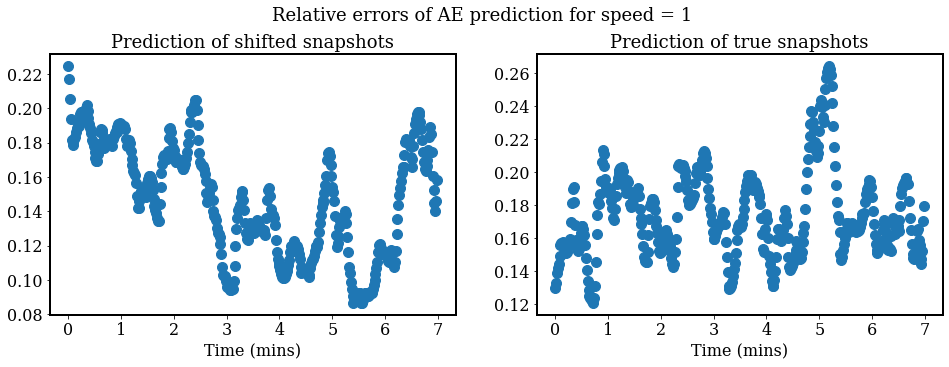

In [47]:
if new_test:
    ### Visualize relative errors for both decoders

    fig = plt.figure(figsize=(16,5))
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    indx = times_new[:snap_end_new+1]/60

    val_dict_new = {'v_data': False, 'v_mark': indx.size, 'v_skip': 1, 'legend': False}
    pu.plot_rel_err(indx, rel_err_shift_new, rel_err_recon_new, val_dict_new, ky='pulse')
    fig.suptitle('Relative errors of AE prediction for speed = %d'%(c_new),fontsize=18, y=0.98)
